# Energy Load Forecast with Visualization in Interactive Tool

In this notebook, we will show how to use NeuralProphet to forecast energy load and visualize the results in an interactive tool. The forecast is based on the [RE-Europe data set](https://github.com/DTU-ELMA/European_Dataset), which models the continental European electricity system, including demand and renewable energy inflows for the period 2012-2014. The total data set comprises 1494 buses, which we will reduce to 5 buses for the purpose of this example.

In [1]:
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet, set_log_level

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact_manual

# Set plotting backend to plotly for interactive plots and plotly-static for static plots
plotting_backend = "plotly-static"

The dataset includes for every bus and every hour of the year the following information:
* load (MW)
* actual solar production (MW)
* forecasted solar production (MW)

The forecasts are at hour 00 of every day for the next 24 hours.

In [2]:
# load data
df = pd.read_csv(
    "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/multivariate/ER_Europe_subset_10nodes.csv"
)
df["ID"] = df["ID"].astype(str)
IDs = df["ID"].unique()
df["ds"] = pd.to_datetime(df["ds"])

# use one year for faster training
df = df[df["ds"] > "2014-01-01"]

df.head()

,ds,ID,y,solar,solar_fcs
17545,2014-01-01 01:00:00,1,72.3142,0.0,0.0
17546,2014-01-01 02:00:00,1,67.5617,0.0,0.0
17547,2014-01-01 03:00:00,1,63.0677,0.0,0.0
17548,2014-01-01 04:00:00,1,59.9401,0.0,0.0
17549,2014-01-01 05:00:00,1,58.9296,0.0,0.0


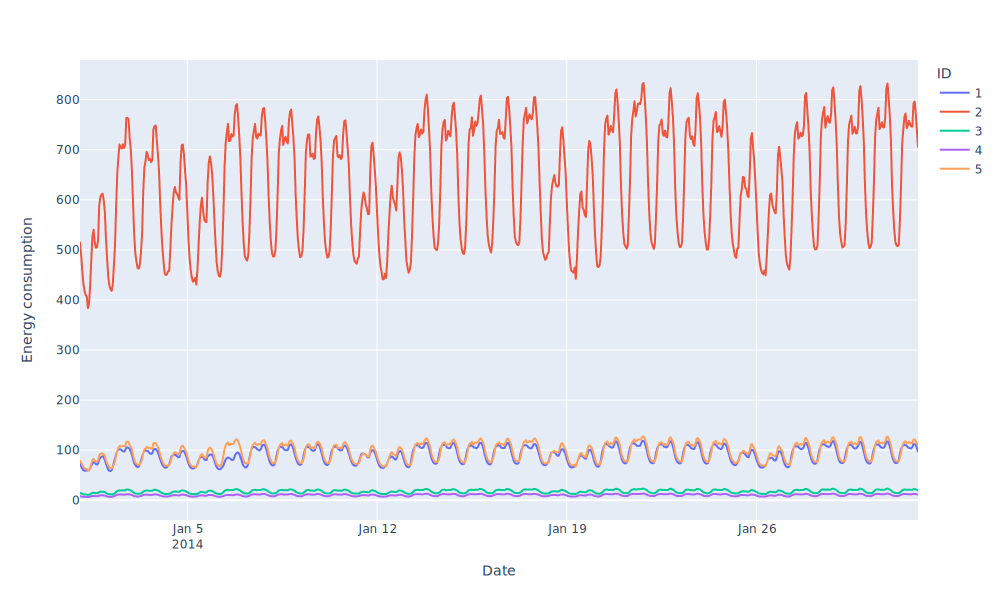

In [21]:
# plot first month of data
fig = px.line(df[df["ds"] < "2014-02-01"], x="ds", y="y", color="ID")

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Energy consumption",
    legend_title="ID",
    height=600,
    width=1000,
)

if plotting_backend == "plotly-static":
    fig.show("svg")

## 1. Data Preparation
To better capture different seasons of the year and days of the week, we add conditional seasonaility. For every season of the year (summer, winter, fall and spring) and weekdays/weekend a separate seasonality is modelled. 

In [5]:
# Conditional Seasonality: 4 Seasons for yearly and weekly seasonality
df["summer"] = 0
df.loc[df["ds"].dt.month.isin([6, 7, 8]), "summer"] = 1
df["winter"] = 0
df.loc[df["ds"].dt.month.isin([12, 1, 2]), "winter"] = 1
df["fall"] = 0
df.loc[df["ds"].dt.month.isin([9, 10, 11]), "fall"] = 1
df["spring"] = 0
df.loc[df["ds"].dt.month.isin([3, 4, 5]), "spring"] = 1

# Conditional Seasonality: 4 Seasons, Weekday/Weekend distinction for each season, for daily seasonality
df["summer_weekday"] = 0
df.loc[(df["ds"].dt.month.isin([6, 7, 8])) & (df["ds"].dt.dayofweek.isin([0, 1, 2, 3, 4])), "summer_weekday"] = 1
df["summer_weekend"] = 0
df.loc[(df["ds"].dt.month.isin([6, 7, 8])) & (df["ds"].dt.dayofweek.isin([5, 6])), "summer_weekend"] = 1

df["winter_weekday"] = 0
df.loc[(df["ds"].dt.month.isin([12, 1, 2])) & (df["ds"].dt.dayofweek.isin([0, 1, 2, 3, 4])), "winter_weekday"] = 1
df["winter_weekend"] = 0
df.loc[(df["ds"].dt.month.isin([12, 1, 2])) & (df["ds"].dt.dayofweek.isin([5, 6])), "winter_weekend"] = 1

df["spring_weekday"] = 0
df.loc[(df["ds"].dt.month.isin([3, 4, 5])) & (df["ds"].dt.dayofweek.isin([0, 1, 2, 3, 4])), "spring_weekday"] = 1
df["spring_weekend"] = 0
df.loc[(df["ds"].dt.month.isin([3, 4, 5])) & (df["ds"].dt.dayofweek.isin([5, 6])), "spring_weekend"] = 1

df["fall_weekday"] = 0
df.loc[(df["ds"].dt.month.isin([9, 10, 11])) & (df["ds"].dt.dayofweek.isin([0, 1, 2, 3, 4])), "fall_weekday"] = 1
df["fall_weekend"] = 0
df.loc[(df["ds"].dt.month.isin([9, 10, 11])) & (df["ds"].dt.dayofweek.isin([5, 6])), "fall_weekend"] = 1

df.head()

,ds,ID,y,solar,solar_fcs,summer,winter,fall,spring,summer_weekday,summer_weekend,winter_weekday,winter_weekend,spring_weekday,spring_weekend,fall_weekday,fall_weekend
17545,2014-01-01 01:00:00,1,72.3142,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0
17546,2014-01-01 02:00:00,1,67.5617,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0
17547,2014-01-01 03:00:00,1,63.0677,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0
17548,2014-01-01 04:00:00,1,59.9401,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0
17549,2014-01-01 05:00:00,1,58.9296,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0


## 2. Model definition
The best parameters for the model can be obtained with hyperparameter tuning. By setting the quantiles, a prediction interval is modelled instead of a point forecast.

In [6]:
# Model and prediction
quantiles = [0.015, 0.985]

params = {
    "n_lags": 7 * 24,
    "n_forecasts": 24,
    "n_changepoints": 20,
    "learning_rate": 0.01,
    "ar_layers": [32, 16, 16, 32],
    "yearly_seasonality": 10,
    "weekly_seasonality": False,
    "daily_seasonality": False,
    "epochs": 40,
    "batch_size": 1024,
    "quantiles": quantiles,
}


m = NeuralProphet(**params)
m.set_plotting_backend(plotting_backend)
set_log_level("ERROR")

### 2.1 Lagged and future regressors
With additional information, our model can get better. We use the last 10 days of the actual solar production as lagged regressor and the solar forecast as the future regressor.

In [7]:
m.add_lagged_regressor(names="solar", n_lags=10 * 24)
m.add_future_regressor(name="solar_fcs")

### 2.2 Conditional seasonalities

In [8]:
m.add_seasonality(name="summer_weekly", period=7, fourier_order=14, condition_name="summer")
m.add_seasonality(name="winter_weekly", period=7, fourier_order=14, condition_name="winter")
m.add_seasonality(name="spring_weekly", period=7, fourier_order=14, condition_name="spring")
m.add_seasonality(name="fall_weekly", period=7, fourier_order=14, condition_name="fall")

m.add_seasonality(name="summer_weekday", period=1, fourier_order=6, condition_name="summer_weekday")
m.add_seasonality(name="winter_weekday", period=1, fourier_order=6, condition_name="winter_weekday")
m.add_seasonality(name="spring_weekday", period=1, fourier_order=6, condition_name="spring_weekday")
m.add_seasonality(name="fall_weekday", period=1, fourier_order=6, condition_name="fall_weekday")

m.add_seasonality(name="summer_weekend", period=1, fourier_order=6, condition_name="summer_weekend")
m.add_seasonality(name="winter_weekend", period=1, fourier_order=6, condition_name="winter_weekend")
m.add_seasonality(name="spring_weekend", period=1, fourier_order=6, condition_name="spring_weekend")
m.add_seasonality(name="fall_weekend", period=1, fourier_order=6, condition_name="fall_weekend")

## 3. Model training
To test our model later, data is split into training and test data. The test data is the last 5% of the data. The model is trained on the training data.

In [9]:
# Split Train and Test Data
df_train, df_test = m.split_df(df, valid_p=0.05, local_split=True)
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (41545, 17)
Test shape: (3090, 17)


In [10]:
# Fit model
metrics_fit = m.fit(df_train, freq="H", metrics=True)

Training: 0it [00:00, ?it/s]

In [11]:
# Predict
forecast = m.predict(df)

Predicting: 40it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarnin

Predicting: 40it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarnin

Predicting: 40it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarnin

Predicting: 40it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarnin

Predicting: 40it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


WARNING - (py.warnings._showwarnmsg) - /Users/leoniewagner/Documents/Uni/Stanford/dev_code/neural_prophet/neuralprophet/data/process.py:127: PerformanceWarnin

In [12]:
# extract season columns and convert to numeric
season_cols = [col for col in forecast.columns if "season" in col or "trend" in col]
forecast[season_cols] = forecast[season_cols].apply(pd.to_numeric)

## 4. Visualization

### 4.1 Model plots
NeuralProphet includes plot functions to explore the forecasted data. For an overview over the plot functions see the [Visualizing tutorial](https://neuralprophet.com/how-to-guides/feature-guides/plotly.html).

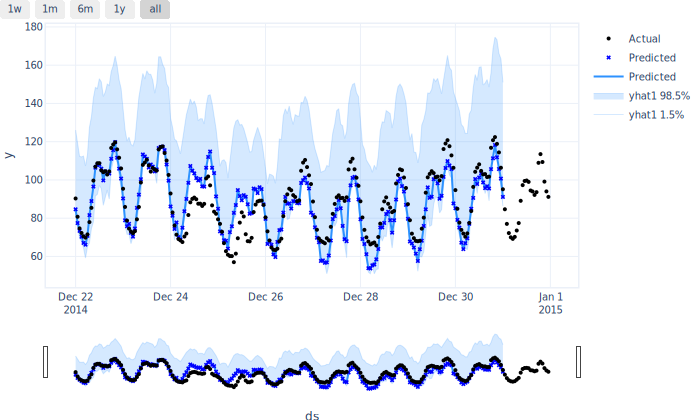

In [13]:
m.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast.iloc[-10 * 24 :])

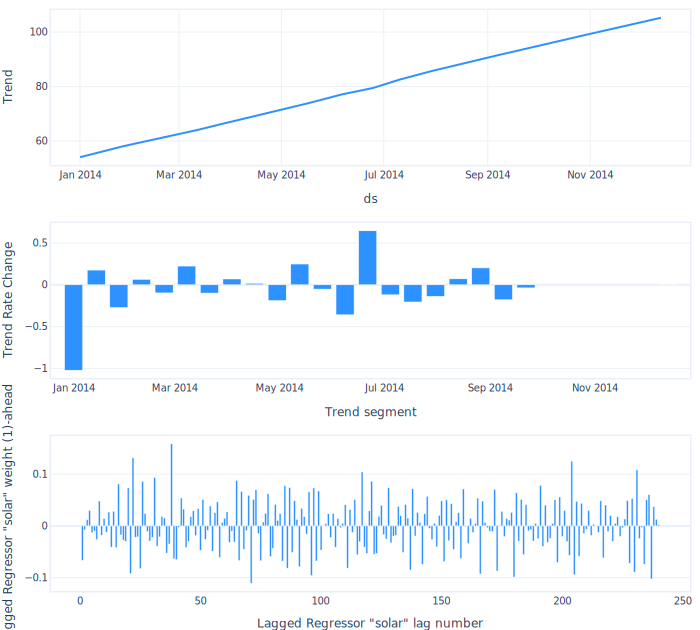

In [14]:
m.plot_parameters(components=["trend", "trend_rate_change", "lagged_regressors"])

### 4.2 Interactive tool
Let's explore the data more interactively. By choosing a date, the forecast for the next 24 hours is shown, which represents industry standards. 

In [15]:
# bring into MISO format: from a given date at 2pm, the forecast is for the next day, 24 hours, starting at midnight
def get_day_ahead_format(date, ID, column_name):
    values = pd.DataFrame(columns=["ds", column_name])
    forecast_ID = forecast[forecast["ID"] == ID]
    for i in range(0, 24):
        if "%" in column_name:
            step_name = f"yhat{i+1} {column_name}"  # eg yhat10 1.5%
        else:
            step_name = f"{column_name}{i+1}"
        ds = date + pd.Timedelta(hours=i + 1)

        # throw an error if the date is not in the forecast
        if ds not in forecast_ID["ds"].values:
            raise ValueError(
                f'The date {ds} is not in the forecast. Please choose a date between {forecast_ID["ds"].min()} and {forecast_ID["ds"].max()}'
            )

        step_value = forecast_ID[forecast_ID["ds"] == ds][step_name].values[0]
        # concatenate the values
        values = pd.concat([values, pd.DataFrame({"ds": ds, column_name: step_value}, index=[0])], ignore_index=True)

    return values

In [19]:
@interact_manual
def show_forecast_uncertainty(ID=IDs, date=widgets.DatePicker()):
    start = pd.to_datetime(date)
    end = start + pd.DateOffset(days=1)

    # get forecast
    np_yhats = get_day_ahead_format(start, ID, "yhat")
    np_yhats_lower = get_day_ahead_format(start, ID, "1.5%")
    np_yhats_upper = get_day_ahead_format(start, ID, "98.5%")
    np_ar = get_day_ahead_format(start, ID, "ar")

    # get actual, temp and temp forecast
    forecast_window = forecast[forecast["ID"] == ID]
    forecast_window = forecast_window[(forecast_window["ds"] >= start) & (forecast_window["ds"] < end)]
    df_window = df[df["ID"] == ID]
    df_window = df_window[(df_window["ds"] >= start) & (df_window["ds"] < end)]

    # get components
    seasonalities_to_plot = []
    for season in season_cols:
        if np.abs(forecast_window[season].sum()) > 0:
            seasonalities_to_plot.append(season)

    fig = make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        subplot_titles=("Actuals and Forecast", "Solar production", "Forecast Components"),
    )

    # plot actuals
    fig.add_trace(
        go.Scatter(
            x=forecast_window["ds"], y=forecast_window["y"], name="Actuals", mode="markers", marker=dict(symbol="x")
        ),
        row=1,
        col=1,
    )

    # plot forecast and uncertainty
    fig.add_trace(
        go.Scatter(
            x=np_yhats_lower["ds"],
            y=np_yhats_lower["1.5%"],
            fill=None,
            mode="lines",
            line_color="#A6B168",
            name="1.5% quantile",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=np_yhats_upper["ds"],
            y=np_yhats_upper["98.5%"],
            fill="tonexty",
            mode="lines",
            line_color="#A6B168",
            name="98.5% quantile",
        ),
        row=1,
        col=1,
    )
    fig.add_trace(go.Scatter(x=np_yhats["ds"], y=np_yhats["yhat"], name="Forecast", line_color="#7A863B"), row=1, col=1)

    # plot solar
    fig.add_trace(
        go.Scatter(x=df_window["ds"], y=df_window["solar"], mode="lines", name="Solar actual production"), row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_window["ds"], y=df_window["solar_fcs"], mode="lines", name="Solar forecast production"),
        row=2,
        col=1,
    )

    # plot different seasons of seasons_to_plot
    for season in seasonalities_to_plot:
        fig.add_trace(go.Scatter(x=forecast_window["ds"], y=forecast_window[season], name=season), row=3, col=1)
    fig.add_trace(go.Scatter(x=np_ar["ds"], y=np_ar["ar"], name="Autoregression"), row=3, col=1)

    fig.update_layout(
        title=f"Forecast for ID {ID} on {date}",
        yaxis=dict(title="Load (MW)"),
        width=1200,
        height=800,
    )

    if plotting_backend == "plotly-static":
        fig.show("svg")
    else:
        fig.show()

interactive(children=(Dropdown(description='ID', options=('1', '2', '3', '4', '5'), value='1'), DatePicker(val…